## 학습

In [ ]:
import os
# --- [1. OpenMP 에러 방지] ---
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import ast
import yaml
from pathlib import Path

# Ultralytics 공식 트레이너 관련
from ultralytics import YOLO
from ultralytics.models.yolo.detect import DetectionTrainer

# ==========================================
# 2. 설정 (Configuration)
# ==========================================
CONFIG = {
    'base_dir': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset',
    'manifest_path': r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_512_folds.csv',
    
    'pretrained_model': 'yolo26s.pt', 
    'save_dir_root': './runs/rsna_5fold_512',
    'img_size': 512,
    'batch_size': 16,
    'epochs': 100,         # [테스트] 1 에폭
    'patience': 10,
    'workers': 0,
    'folds_to_run': [1]  # [테스트] Fold 1만
}

def create_dummy_structure(base_dir):
    fake_dirs = [
        os.path.join(base_dir, 'images', 'train'), os.path.join(base_dir, 'images', 'val'),
        os.path.join(base_dir, 'labels', 'train'), os.path.join(base_dir, 'labels', 'val')
    ]
    for d in fake_dirs: os.makedirs(d, exist_ok=True)

# ==========================================
# 3. 데이터셋 (512px 대응)
# ==========================================
class RSNA4ChannelDataset(Dataset):
    def __init__(self, df, base_dir):
        self.df = df
        self.base_dir = base_dir
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        full_path = os.path.join(self.base_dir, row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                img = loaded['data'].astype(np.float32)
                h, w = img.shape[1], img.shape[2] 
        except:
            img = np.zeros((4, CONFIG['img_size'], CONFIG['img_size']), dtype=np.float32)
            h, w = CONFIG['img_size'], CONFIG['img_size']

        boxes = [] 
        try:
            fracture_flag = int(float(row['fracture']))
        except:
            fracture_flag = 0
            
        if fracture_flag == 1 and pd.notna(row['bbox']):
            try:
                raw_boxes = row['bbox']
                if isinstance(raw_boxes, str):
                    if 'np.float64' in raw_boxes:
                        raw_boxes = raw_boxes.replace('np.float64(', '').replace(')', '')
                    raw_boxes = ast.literal_eval(raw_boxes)
                
                if isinstance(raw_boxes, list):
                    for box in raw_boxes:
                        if len(box) == 4:
                            x, y, w_box, h_box = box
                            cx, cy = x + w_box/2, y + h_box/2
                            try:
                                cls = int(float(row['ver_level'])) - 1 
                            except:
                                cls = -1
                            if 0 <= cls < 7:
                                boxes.append([cls, cx, cy, w_box, h_box])
            except Exception as e:
                pass
        
        boxes = torch.tensor(boxes, dtype=torch.float32) if boxes else torch.zeros((0, 5))
        img_tensor = torch.from_numpy(img)
        
        return img_tensor, boxes, (h, w), full_path

# [학습용] Ultralytics 포맷 Collate
def trainer_collate_fn(batch):
    images, box_lists, shapes, paths = zip(*batch)
    images = torch.stack(images, 0)
    
    new_boxes = []
    for i, boxes in enumerate(box_lists):
        if boxes.shape[0] > 0:
            idx_col = torch.full((boxes.shape[0], 1), i, dtype=torch.float32)
            combined = torch.cat([idx_col, boxes], dim=1)
            new_boxes.append(combined)
    targets = torch.cat(new_boxes, 0) if new_boxes else torch.zeros((0, 6))
    
    return {
        'img': images,
        'batch_idx': targets[:, 0],
        'cls': targets[:, 1].view(-1, 1),
        'bboxes': targets[:, 2:],
        'device': None,
        'ori_shape': list(shapes),
        'resized_shape': list(shapes),
        'im_file': list(paths),
        'ratio_pad': [((1.0, 1.0), (0.0, 0.0)) for _ in range(len(images))] 
    }

# [검증용] 단순 Collate (박스 합치지 않음) -> 에러 해결의 열쇠!
def val_collate_fn(batch):
    images, box_lists, shapes, paths = zip(*batch)
    # 이미지만 쌓고, 박스는 리스트(튜플) 상태로 유지
    images = torch.stack(images, 0)
    return images, box_lists, shapes, paths

# ==========================================
# 4. 커스텀 트레이너
# ==========================================
class RSNATrainer(DetectionTrainer):
    def __init__(self, overrides=None, current_fold=1):
        self.current_fold = current_fold
        super().__init__(overrides=overrides)

    def build_dataset(self, img_path, mode="train", batch=None):
        df = pd.read_csv(CONFIG['manifest_path'])
        if mode == "train":
            sub_df = df[df['fold'] != self.current_fold].reset_index(drop=True)
        else:
            sub_df = df[df['fold'] == self.current_fold].reset_index(drop=True)
            
        print(f"Dataset Build ({mode}): {len(sub_df)} samples loaded.")
        return RSNA4ChannelDataset(sub_df, CONFIG['base_dir'])

    def get_dataloader(self, dataset_path, batch_size=16, rank=0, mode="train"):
        if hasattr(self, 'data') and isinstance(self.data, dict):
            self.data['channels'] = 4
            self.data['ch'] = 4
            
        dataset = self.build_dataset(dataset_path, mode)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=(mode == "train"),
                            num_workers=0, collate_fn=trainer_collate_fn, pin_memory=True)
        loader.reset = lambda: None
        return loader

    def get_model(self, cfg=None, weights=None, verbose=True):
        target_weights = weights if weights else 'yolov8s.pt'
        print(f"📦 [Trainer] 모델 로드 시도: {target_weights}")
        try:
            temp_yolo = YOLO(target_weights)
        except Exception as e:
            print(f"⚠️ {target_weights} 로드 실패, yolov8s.pt로 대체합니다.")
            target_weights = 'yolov8s.pt'
            temp_yolo = YOLO(target_weights)

        model = temp_yolo.model
        m = model.model[0]
        if isinstance(m.conv, nn.Conv2d) and m.conv.in_channels == 3:
            old_conv = m.conv
            new_conv = nn.Conv2d(4, old_conv.out_channels, 
                                 kernel_size=old_conv.kernel_size, stride=old_conv.stride, 
                                 padding=old_conv.padding, bias=(old_conv.bias is not None))
            with torch.no_grad():
                new_conv.weight[:, :3] = old_conv.weight
                new_conv.weight[:, 3] = old_conv.weight.mean(dim=1)
                if old_conv.bias is not None: new_conv.bias = old_conv.bias
            m.conv = new_conv
            m.c1 = 4
            print("🔧 Conv1 4채널 확장 완료")
        return model

    def final_eval(self):
        print("⚠️ [Info] Ultralytics 내부 final_eval 건너뜀")
        return

    def plot_training_labels(self, *args, **kwargs): pass 

# ==========================================
# 5. 커스텀 메트릭 (수정됨)
# ==========================================
def calculate_custom_metrics(model_path, val_fold, device):
    print(f"\n📊 [Fold {val_fold}] 커스텀 메트릭 계산 시작...")
    
    df = pd.read_csv(CONFIG['manifest_path'])
    val_df = df[df['fold'] == val_fold].reset_index(drop=True)
    val_ds = RSNA4ChannelDataset(val_df, CONFIG['base_dir'])
    
    # [수정] collate_fn=val_collate_fn 추가! -> 에러 해결
    val_loader = DataLoader(val_ds, batch_size=CONFIG['batch_size'], shuffle=False, 
                            num_workers=0, collate_fn=val_collate_fn)

    # 평가용 모델 로드
    temp_trainer = RSNATrainer(overrides={'model': 'yolov8s.pt', 'data': 'rsna_dummy.yaml'}, current_fold=val_fold)
    
    if os.path.exists(model_path):
        model = temp_trainer.get_model(weights=str(model_path))
    else:
        print(f"❌ [Critical] 가중치 파일 없음: {model_path}")
        return 0.0, 0.0

    model.to(device)
    model.eval()

    preds_prob = []
    targets = []

    with torch.no_grad():
        for img, boxes, _, _ in val_loader:
            img = img.to(device)
            output = model(img)
            pred_tensor = output[0].transpose(1, 2)
            
            for i in range(len(img)):
                p = pred_tensor[i]
                cls_probs = p[:, 4:]
                conf, _ = cls_probs.max(1)
                preds_prob.append(conf.max().item())
            
            # 박스는 리스트 상태이므로 순회 가능
            for b in boxes:
                targets.append(1.0 if b.shape[0] > 0 else 0.0)

    preds_prob = np.array(preds_prob)
    targets = np.array(targets)
    
    acc = ((preds_prob > 0.5) == targets).mean()
    epsilon = 1e-15
    preds_prob = np.clip(preds_prob, epsilon, 1 - epsilon)
    log_loss = -(targets * np.log(preds_prob) + (1 - targets) * np.log(1 - preds_prob)).mean()

    print(f"   👉 Accuracy: {acc:.4f}")
    print(f"   👉 Log Loss: {log_loss:.4f}")
    return acc, log_loss

# ==========================================
# 6. 메인 실행
# ==========================================
if __name__ == '__main__':
    save_root_abs = os.path.abspath(CONFIG['save_dir_root'])
    os.makedirs(save_root_abs, exist_ok=True)
    
    create_dummy_structure(CONFIG['base_dir'])
    
    current_dir = os.getcwd()
    dummy_yaml_path = os.path.abspath(os.path.join(current_dir, "rsna_dummy.yaml"))
    
    with open(dummy_yaml_path, 'w') as f:
        yaml.dump({
            'path': os.path.abspath(CONFIG['base_dir']), 
            'train': 'images/train', 
            'val': 'images/val',
            'nc': 7, 
            'names': ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7'],
            'ch': 4 
        }, f)

    final_results = []
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    for fold in CONFIG['folds_to_run']:
        print(f"\n{'='*40}")
        print(f"🚀 FOLD {fold} 학습 시작")
        print(f"{'='*40}")
        
        project_path = os.path.abspath(CONFIG['save_dir_root'])
        name_path = f'fold_{fold}'
        
        args = dict(
            model=CONFIG['pretrained_model'], 
            data=dummy_yaml_path, 
            epochs=CONFIG['epochs'],
            batch=CONFIG['batch_size'], 
            imgsz=CONFIG['img_size'], 
            device=0 if device == 'cuda' else 'cpu',
            project=project_path,
            name=name_path, 
            exist_ok=True, workers=0,
            val=True, plots=False, amp=True, save=True, patience=CONFIG['patience']
        )

        trainer = RSNATrainer(overrides=args, current_fold=fold)
        trainer.train()
        
        real_save_dir = trainer.save_dir 
        best_pt = real_save_dir / 'weights' / 'best.pt'
        if not best_pt.exists():
            best_pt = real_save_dir / 'weights' / 'last.pt'
            
        acc, log_loss = calculate_custom_metrics(best_pt, fold, device)
        
        yolo_res_path = real_save_dir / 'results.csv'
        map50 = 0.0
        if yolo_res_path.exists():
            try:
                res_df = pd.read_csv(yolo_res_path)
                res_df.columns = [c.strip() for c in res_df.columns]
                map50 = res_df['metrics/mAP50(B)'].iloc[-1]
            except: pass

        final_results.append({'fold': fold, 'accuracy': acc, 'log_loss': log_loss, 'mAP50': map50})
        pd.DataFrame(final_results).to_csv(os.path.join(save_root_abs, 'rsna_final_summary.csv'), index=False)

    print(f"\n✨ 테스트 완료!")
    print(pd.DataFrame(final_results))


🚀 FOLD 1 학습 시작
Ultralytics 8.4.14  Python-3.12.12 torch-2.9.1+cu130 CUDA:0 (NVIDIA GeForce RTX 5060 Ti, 16311MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=c:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\rsna_dummy.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=100, erasing=0.4, exist_ok=True, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo26s.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=fold_1, nbs=64, nms=

## 학습 결과 시각화

✨ 그래프 저장 완료: ./training_curves.png


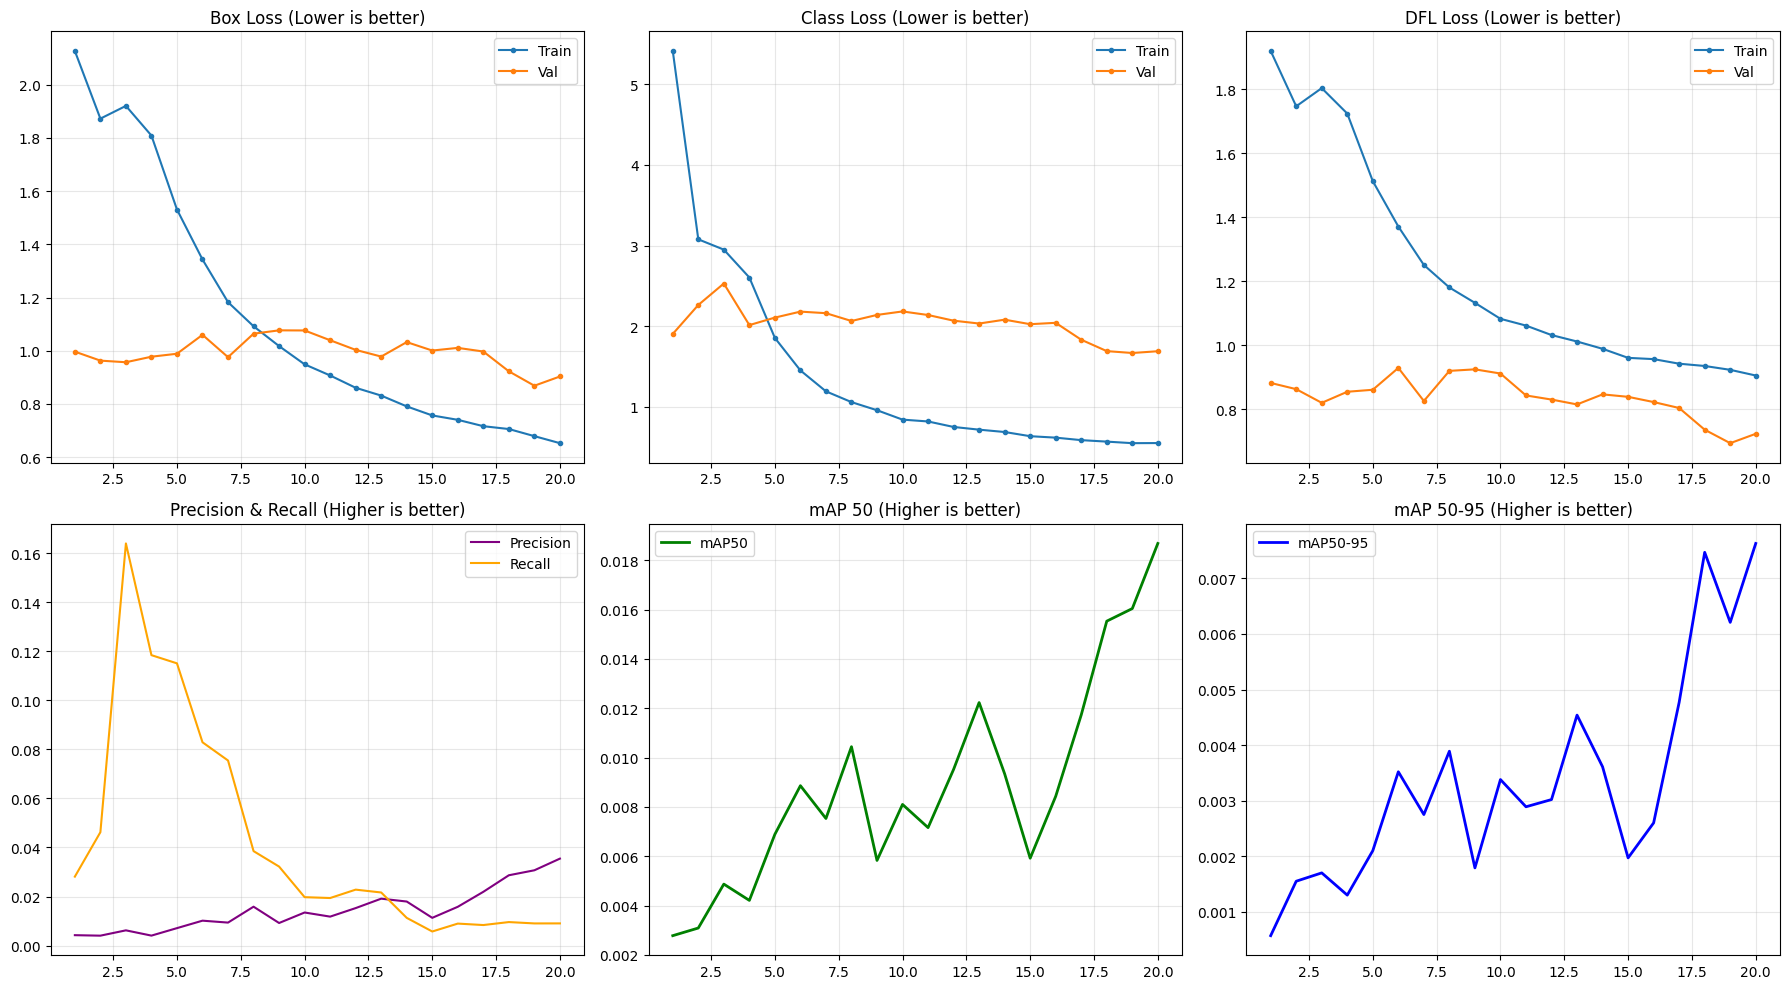

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ==========================================
# [설정] results.csv 경로를 지정하세요
# ==========================================
# 예: runs/rsna_5fold_512/fold_1/results.csv
CSV_PATH = r'./runs/rsna_5fold_512/fold_1/results.csv' 
SAVE_PATH = r'./training_curves.png'

def plot_results():
    if not os.path.exists(CSV_PATH):
        print(f"❌ 파일을 찾을 수 없습니다: {CSV_PATH}")
        return

    # 데이터 로드 (공백 제거)
    df = pd.read_csv(CSV_PATH)
    df.columns = [c.strip() for c in df.columns]

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    epochs = df['epoch']

    # 1. Box Loss
    axes[0, 0].plot(epochs, df['train/box_loss'], label='Train', marker='.')
    axes[0, 0].plot(epochs, df['val/box_loss'], label='Val', marker='.')
    axes[0, 0].set_title('Box Loss (Lower is better)')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Cls Loss
    axes[0, 1].plot(epochs, df['train/cls_loss'], label='Train', marker='.')
    axes[0, 1].plot(epochs, df['val/cls_loss'], label='Val', marker='.')
    axes[0, 1].set_title('Class Loss (Lower is better)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # 3. DFL Loss
    axes[0, 2].plot(epochs, df['train/dfl_loss'], label='Train', marker='.')
    axes[0, 2].plot(epochs, df['val/dfl_loss'], label='Val', marker='.')
    axes[0, 2].set_title('DFL Loss (Lower is better)')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # 4. Precision & Recall
    axes[1, 0].plot(epochs, df['metrics/precision(B)'], label='Precision', color='purple')
    axes[1, 0].plot(epochs, df['metrics/recall(B)'], label='Recall', color='orange')
    axes[1, 0].set_title('Precision & Recall (Higher is better)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # 5. mAP50
    axes[1, 1].plot(epochs, df['metrics/mAP50(B)'], label='mAP50', color='green', linewidth=2)
    axes[1, 1].set_title('mAP 50 (Higher is better)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # 6. mAP50-95
    axes[1, 2].plot(epochs, df['metrics/mAP50-95(B)'], label='mAP50-95', color='blue', linewidth=2)
    axes[1, 2].set_title('mAP 50-95 (Higher is better)')
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(SAVE_PATH)
    print(f"✨ 그래프 저장 완료: {SAVE_PATH}")
    plt.show()

if __name__ == '__main__':
    plot_results()

📦 모델 로딩 중: ./runs/rsna_5fold_512/fold_1/weights/best.pt
🔍 검증 데이터 중 골절 샘플 5개를 수동 추론합니다...


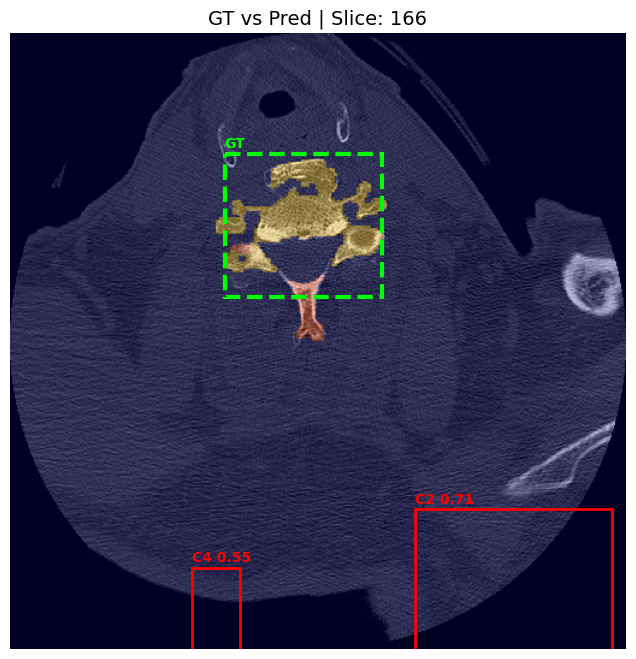

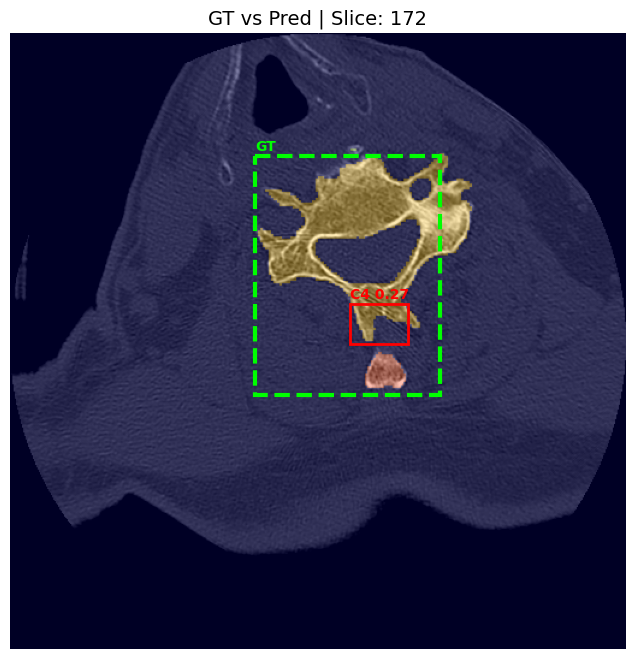

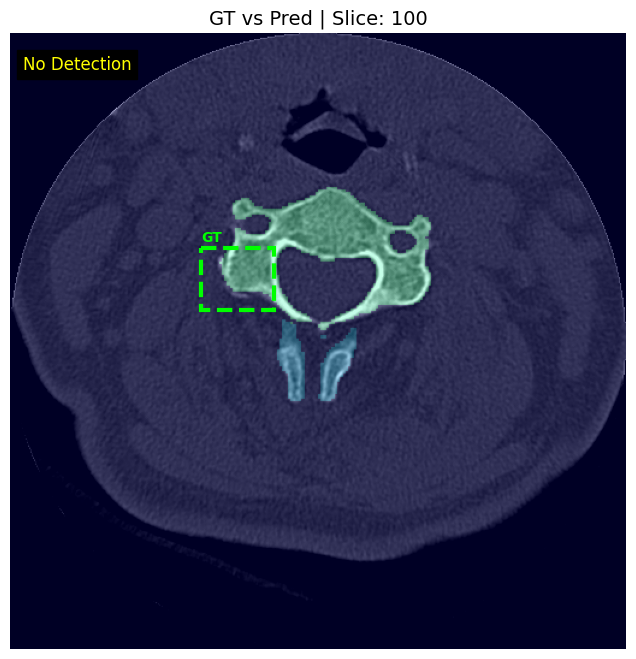

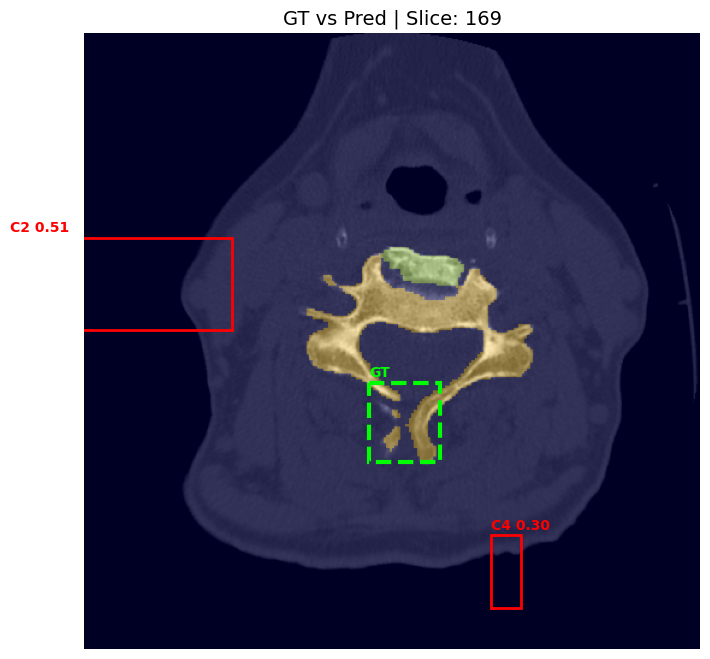

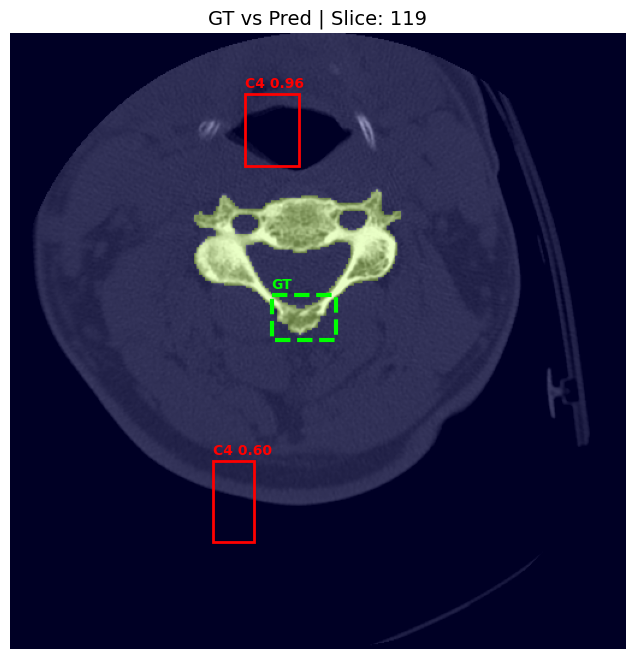

In [7]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ast
import torchvision # PyTorch 공식 NMS 사용
from ultralytics import YOLO

# ==========================================
# [설정] 경로를 본인 환경에 맞게 수정하세요
# ==========================================
BASE_DIR = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset'
MANIFEST_PATH = r'C:\conda\3. Project\rsna-2022-cervical-spine-fracture-detection\golden_dataset\det_train_manifest_512_folds.csv'
MODEL_PATH = r'./runs/rsna_5fold_512/fold_1/weights/best.pt' # 혹은 last.pt
IMG_SIZE = 512
CONF_THRESHOLD = 0.25 
IOU_THRESHOLD = 0.5

def clean_and_parse_box(bbox_str):
    if not isinstance(bbox_str, str): return []
    clean_str = bbox_str.replace('np.float64(', '').replace('np.int64(', '').replace(')', '')
    try:
        return ast.literal_eval(clean_str)
    except: return []

# [핵심] 수동 NMS 및 후처리 함수
def postprocess(pred, conf_thres=0.25, iou_thres=0.45):
    # pred shape: (Batch, 4+Classes, Anchors) -> (Batch, Anchors, 4+Classes)
    pred = pred.transpose(1, 2)
    
    output = []
    for image_pred in pred:
        # 1. Box 변환 (cx, cy, w, h) -> (x1, y1, x2, y2)
        # YOLOv8 출력의 처음 4개 채널은 cx, cy, w, h입니다.
        x_center = image_pred[:, 0]
        y_center = image_pred[:, 1]
        width = image_pred[:, 2]
        height = image_pred[:, 3]
        
        x1 = x_center - width / 2
        y1 = y_center - height / 2
        x2 = x_center + width / 2
        y2 = y_center + height / 2
        
        boxes = torch.stack([x1, y1, x2, y2], dim=1)
        
        # 2. Confidence & Class 점수
        # 4번째 인덱스부터가 클래스 확률입니다.
        scores, class_ids = image_pred[:, 4:].max(dim=1)
        
        # 3. Thresholding
        mask = scores > conf_thres
        boxes = boxes[mask]
        scores = scores[mask]
        class_ids = class_ids[mask]
        
        if boxes.shape[0] == 0:
            output.append(None)
            continue
            
        # 4. NMS (Non-Max Suppression) - torchvision 사용
        keep_indices = torchvision.ops.nms(boxes, scores, iou_thres)
        
        # 최종 결과 필터링
        final_boxes = boxes[keep_indices]
        final_scores = scores[keep_indices]
        final_cls = class_ids[keep_indices]
        
        # (x1, y1, x2, y2, score, cls) 형태로 묶기
        result = torch.cat([
            final_boxes, 
            final_scores.unsqueeze(1), 
            final_cls.float().unsqueeze(1)
        ], dim=1)
        
        output.append(result.cpu().numpy())
        
    return output

def visualize_inference():
    if not os.path.exists(MODEL_PATH):
        print(f"❌ 모델 파일이 없습니다: {MODEL_PATH}")
        return
    
    print(f"📦 모델 로딩 중: {MODEL_PATH}")
    # Ultralytics 래퍼에서 껍데기 벗기고 PyTorch 모델만 꺼냄
    yolo_wrapper = YOLO(MODEL_PATH)
    model = yolo_wrapper.model
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)
    model.eval()
    
    # 데이터 준비
    df = pd.read_csv(MANIFEST_PATH)
    val_df = df[(df['fold'] == 1) & (df['fracture'] == 1)].sample(n=5)
    
    print(f"🔍 검증 데이터 중 골절 샘플 5개를 수동 추론합니다...")

    for idx, row in val_df.iterrows():
        full_path = os.path.join(BASE_DIR, row['file_path'])
        
        try:
            with np.load(full_path) as loaded:
                img_data = loaded['data'].astype(np.float32)
        except Exception as e:
            print(f"load error: {e}")
            continue

        # (4, 512, 512) -> (1, 4, 512, 512)
        input_tensor = torch.from_numpy(img_data).unsqueeze(0).to(device)
        
        with torch.no_grad():
            # [핵심] 순수 모델 직접 호출 (전처리/후처리 자동개입 차단)
            raw_output = model(input_tensor)
            
            # YOLOv8의 출력은 튜플일 수 있음 (inference, loss_features)
            if isinstance(raw_output, (tuple, list)):
                raw_output = raw_output[0]
                
            # 수동 후처리 (NMS)
            detections = postprocess(raw_output, CONF_THRESHOLD, IOU_THRESHOLD)[0]

        # 시각화
        fig, ax = plt.subplots(1, 1, figsize=(8, 8))
        ax.imshow(img_data[1], cmap='gray')
        ax.imshow(img_data[3], cmap='jet', alpha=0.3, vmin=0, vmax=1)

        # --- GT ---
        gt_boxes = clean_and_parse_box(row['bbox'])
        for box in gt_boxes:
            if len(box) == 4:
                nx, ny, nw, nh = box
                x, y, w, h = nx*IMG_SIZE, ny*IMG_SIZE, nw*IMG_SIZE, nh*IMG_SIZE
                rect = patches.Rectangle((x, y), w, h, linewidth=3, edgecolor='lime', facecolor='none', linestyle='--')
                ax.add_patch(rect)
                ax.text(x, y-5, 'GT', color='lime', fontweight='bold')

        # --- Pred ---
        if detections is not None:
            for det in detections:
                x1, y1, x2, y2, conf, cls = det
                w_p, h_p = x2 - x1, y2 - y1
                rect = patches.Rectangle((x1, y1), w_p, h_p, linewidth=2, edgecolor='red', facecolor='none')
                ax.add_patch(rect)
                ax.text(x1, y1-5, f"C{int(cls)+1} {conf:.2f}", color='red', fontweight='bold')
        else:
             ax.text(10, 30, "No Detection", color='yellow', fontsize=12, backgroundcolor='black')

        ax.axis('off')
        ax.set_title(f"GT vs Pred | Slice: {row['slice_idx']}", fontsize=14)
        plt.show()

if __name__ == '__main__':
    visualize_inference()

In [4]:
!pip install -U ultralytics